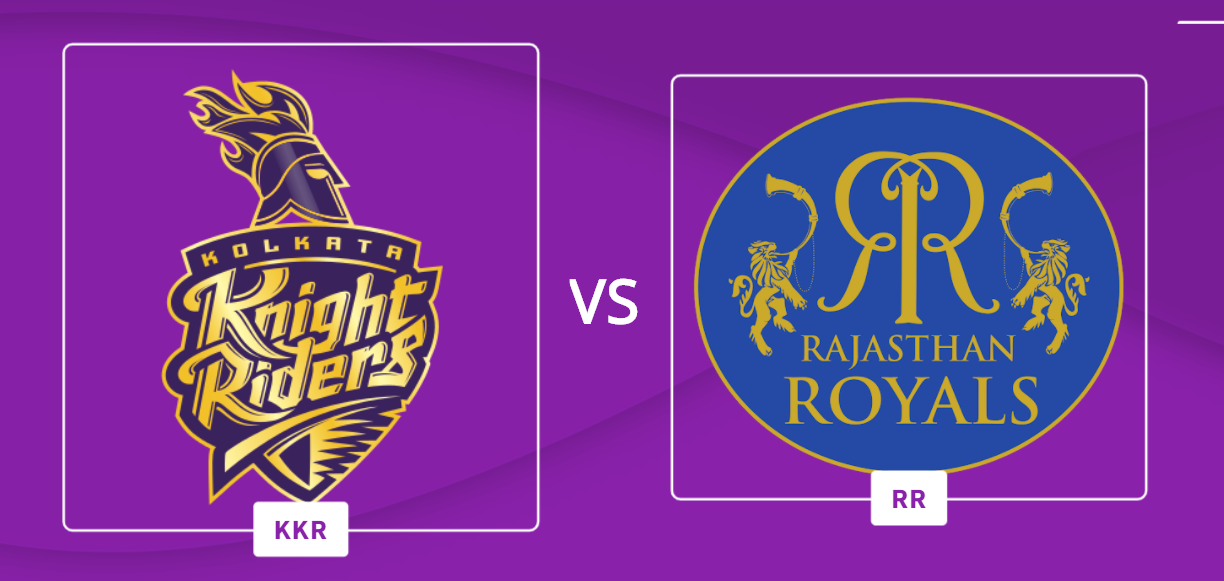

In [1]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [2]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [4]:
#KKR batsmen
KKR_batsmen = ['S Gill', 'N Rana', 'RA Tripathi',  'KD Karthik', 'EJG Morgan', 'SP Narine', 'PJ Cummins']
# SP Narine/AD Russell(optional)

#KKR bowlers
KKR_bowlers = ['PJ Cummins',  'P Krishna' , 'LH Ferguson', 'V Chakravarthy', 'SP Narine']
# nagarkoti no data

#RR
RR_bowlers = ['J Archer' , 'AS Rajpoot', 'S Gopal' , 'R Tewatia', 'BA Stokes', 'S Tyagi']
RR_batsmen = ['RV Uthappa','BA Stokes', 'SV Samson', 'SPD Smith', 'JC Buttler', 'R Tewatia','R Parag','J Archer']


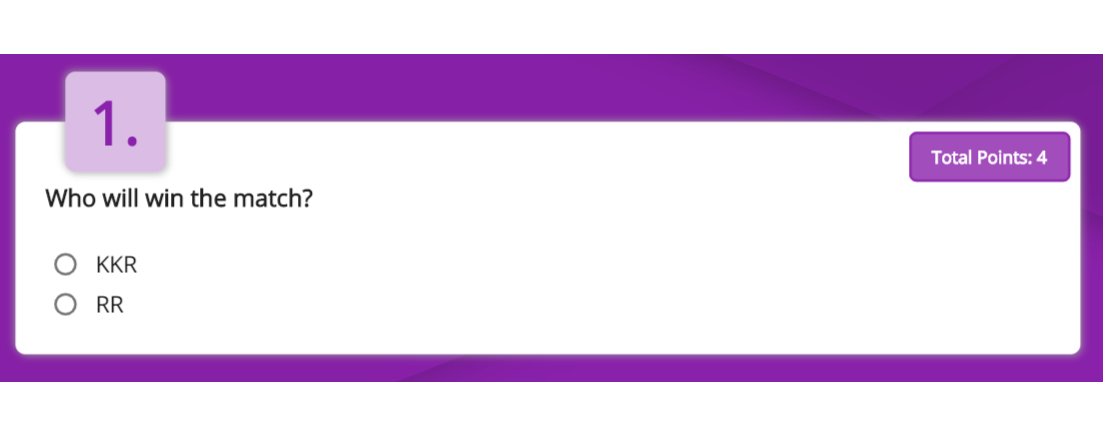

In [165]:

bowling_avg = deliveries[(deliveries.bowler.isin(KKR_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(KKR_bowlers)], b_avg1[b_avg1.bowler.isin(RR_bowlers)]], 
                     [" 1) bowling average of KKR bowlers", " 2) bowling average of RR bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(KKR_batsmen)) | (deliveries.batsman.isin(RR_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out

display_side_by_side([bat_avg[bat_avg.batsman.isin(KKR_batsmen)], bat_avg[bat_avg.batsman.isin(RR_batsmen)]],
                     [" 1) batting average of KKR batsmen", " 2) batting average of RR batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
3,LH Ferguson,5,87,0.057471
4,P Krishna,16,437,0.036613
5,PJ Cummins,19,379,0.050132
9,SP Narine,137,2600,0.052692
10,V Chakravarthy,1,18,0.055556
,bowler,wickets,balls_bowled,bowling_avg
0,AS Rajpoot,22,452,0.048673
1,BA Stokes,29,615,0.047154
2,J Archer,27,514,0.052529
6,R Tewatia,16,301,0.053156


,batsman,matches_out,matches,total_runs,batting_average
1,N Rana,40,41,1104,27.600000
4,KD Karthik,140,162,3688,26.342857
6,PJ Cummins,6,9,77,12.833333
8,SP Narine,40,54,803,20.075000
9,RA Tripathi,27,33,771,28.555556
10,EJG Morgan,38,45,854,22.473684
12,S Gill,14,23,517,36.928571
,batsman,matches_out,matches,total_runs,batting_average
0,JC Buttler,38,45,1431,37.657895
2,SPD Smith,59,72,2047,34.694915


In [168]:
fig11 = px.bar(b_avg1, x="bowler", y='bowling_avg',
             hover_data=['bowler', 'bowling_avg', 'balls_bowled','wickets' ],color = 'bowler',
             title='Bowling averages of KKR and RR bowlers')
#fig11.show()

fig22 = px.bar(bat_avg, x="batsman", y='batting_average',
             hover_data=['batsman', 'batting_average', 'total_runs','matches', 'matches_out' ],color = 'batsman',
             title='Batting averages of KKR and RR batsmen')
#fig22.show()

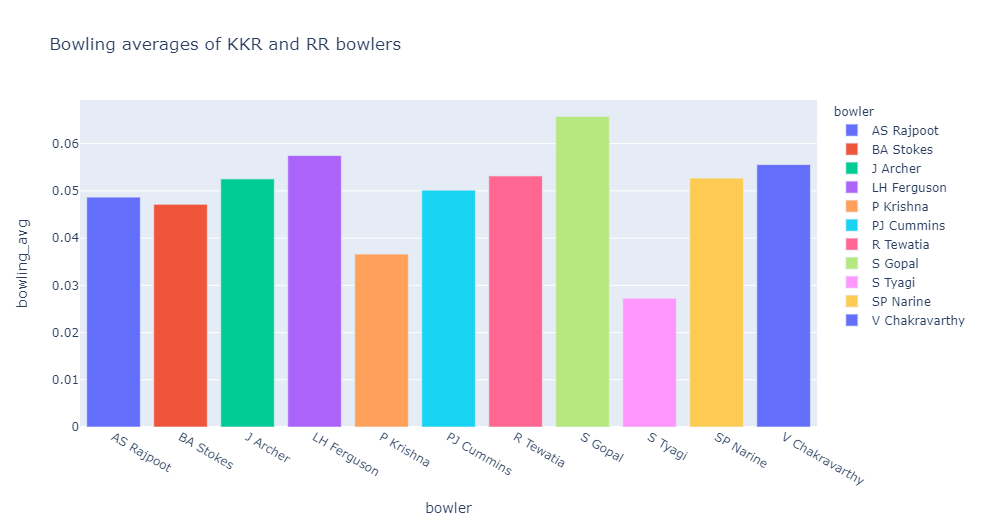

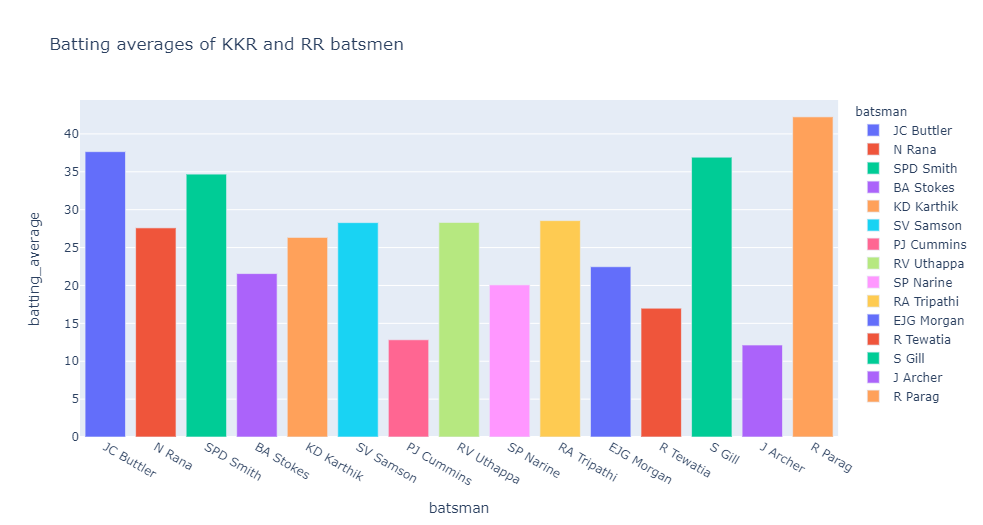

## Performance indexes of batsmen
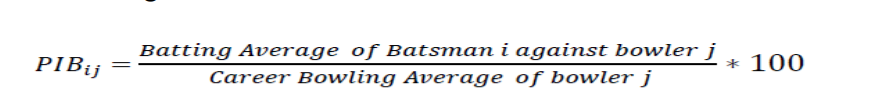

In [169]:
# Performance indexes of KKR batsmen against RR bowlers
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
def performance_indexes_batsmen(batsman_list, bowler_list):
    
    for i in batsman_list:
        pi1 = deliveries[(deliveries.batsman == i) & (deliveries.bowler.isin(bowler_list))]
        pi1.player_dismissed.fillna(0, inplace = True)
        pi1['player_dismissed'].loc[pi1['player_dismissed'] != 0] = 1
        for j in pi1.bowler.unique():
            x = pi1[pi1.bowler == j]
            batsman.append(i)
            bowler.append(j)
            y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
            z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
            b_avg.append(y.out_count.sum())
            runs.append(z.runs.sum())
            tm.append(y.shape[0])
            
performance_indexes_batsmen(KKR_batsmen, RR_bowlers)
KKR_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
KKR_bat_avg["batting_average"] = KKR_bat_avg.total_runs/KKR_bat_avg.matches_out
KKR_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg = []
for i in KKR_bat_avg.bowler.values:
    bowl_avg.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
KKR_bat_avg["bowling_average_bowler"] = bowl_avg
KKR_bat_avg["PIBij"] = KKR_bat_avg.batting_average/KKR_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %

#############################################################################################################33
# RR batsmen's performance indexes
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
performance_indexes_batsmen(RR_batsmen, KKR_bowlers)

RR_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
RR_bat_avg["batting_average"] = RR_bat_avg.total_runs/RR_bat_avg.matches_out
RR_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg1 = []
for i in RR_bat_avg.bowler.values:
    bowl_avg1.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
RR_bat_avg["bowling_average_bowler"] = bowl_avg1
RR_bat_avg["PIBij"] = RR_bat_avg.batting_average/RR_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %
display_side_by_side([RR_bat_avg, KKR_bat_avg],
                     [" 1) Performance indexes of RR batsmen against KKR Bowlers", " 2) Performance indexes of KKR batsmen against RR Bowlers"])

,batsman,bowler,matches_out,total_matches,total_runs,batting_average,bowling_average_bowler,PIBij
0,RV Uthappa,PJ Cummins,1,2,18,18.000000,0.050132,359.052632
1,RV Uthappa,SP Narine,0,2,2,nan,0.052692,nan
2,RV Uthappa,V Chakravarthy,0,1,10,nan,0.055556,nan
3,BA Stokes,PJ Cummins,1,2,8,8.000000,0.050132,159.578947
4,BA Stokes,SP Narine,1,4,17,17.000000,0.052692,322.627737
5,BA Stokes,P Krishna,0,1,6,nan,0.036613,nan
6,SV Samson,SP Narine,3,9,39,13.000000,0.052692,246.715328
7,SV Samson,P Krishna,0,2,12,nan,0.036613,nan
8,SPD Smith,SP Narine,2,6,55,27.500000,0.052692,521.897810
9,SPD Smith,P Krishna,0,1,19,nan,0.036613,nan


## Performance indexes for both the teams bowlers
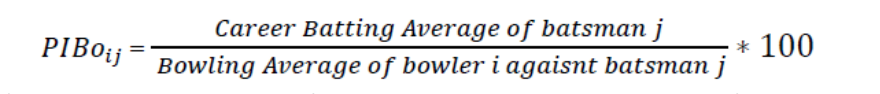

In [170]:
bowls = []; bats = []; wi = []; bb = []
def performance_index_bowlers(bowlers_list, batsmen_list):
    for i in bowlers_list:
        p = deliveries[(deliveries.bowler == i) & (deliveries.batsman.isin(batsmen_list))]
        p.player_dismissed.fillna(0, inplace  = True)
        p['player_dismissed'].loc[p['player_dismissed'] != 0] = 1
        for j in p.batsman.unique():
            bowls.append(i)
            bats.append(j)
            xy = p[p.batsman == j]
            #print(p[p.batsman == j])
            wi.append(xy.player_dismissed.sum())
            bb.append(xy.batsman_runs.count())
        
performance_index_bowlers(KKR_bowlers, RR_batsmen)
KKR_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in KKR_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
KKR_bowlers_p["bowling_average"] = KKR_bowlers_p.wickets/KKR_bowlers_p.balls_bowled
KKR_bowlers_p["batting_avg"] = bat_avg_p
KKR_bowlers_p["PIBoij"] = KKR_bowlers_p.batting_avg/KKR_bowlers_p.bowling_average
KKR_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)
###################################################################################################################
bowls = []; bats = []; wi = []; bb = []        
performance_index_bowlers(RR_bowlers, KKR_batsmen)

RR_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in RR_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
RR_bowlers_p["bowling_average"] = RR_bowlers_p.wickets/RR_bowlers_p.balls_bowled
RR_bowlers_p["batting_avg"] = bat_avg_p
RR_bowlers_p["PIBoij"] = RR_bowlers_p.batting_avg/RR_bowlers_p.bowling_average
RR_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)

display_side_by_side([KKR_bowlers_p, RR_bowlers_p],
                     [" 1) Performance indexes of KKR bowlers against RR batsmen", " 2) Performance indexes of RR bowlers against KKR batsmen"])

,bowler,batsman,wickets,balls_bowled,bowling_average,batting_avg,PIBoij
0,PJ Cummins,BA Stokes,1,11,0.090909,21.566667,237.233333
1,PJ Cummins,RV Uthappa,1,11,0.090909,28.318471,311.503185
2,P Krishna,JC Buttler,0,11,0.000000,37.657895,nan
3,P Krishna,SV Samson,0,7,0.000000,28.291139,nan
4,P Krishna,J Archer,0,11,0.000000,12.142857,nan
5,P Krishna,SPD Smith,0,11,0.000000,34.694915,nan
6,P Krishna,BA Stokes,0,7,0.000000,21.566667,nan
7,P Krishna,R Parag,0,6,0.000000,42.250000,nan
8,V Chakravarthy,RV Uthappa,0,7,0.000000,28.318471,nan
9,SP Narine,JC Buttler,1,26,0.038462,37.657895,979.105263


## Conclusion : By comparing above results it seems RR will win today

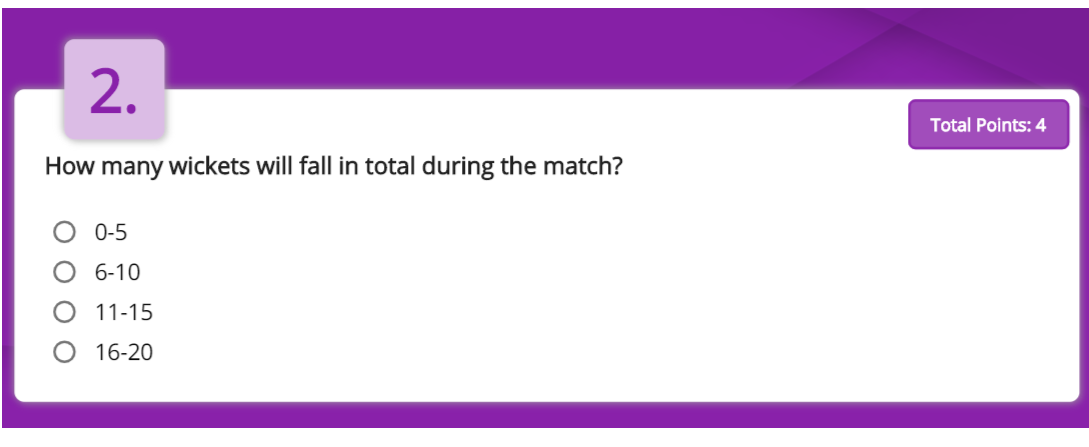

## Function to calculate wickets taken

In [38]:
def wickets_taken(wickets_data_matchwise, match_data):
    for i in wickets_data_matchwise.bowler.unique():
        bowler.append(i)
        wi.append(round(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].wickets.mean(),1))
        more_wickets.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i][wickets_data_matchwise.wickets >1].match_id.unique()))
        wicket_matches.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].match_id.unique()))
        
        t_matches.append(len(match_data[match_data.bowler == i].match_id.unique()))
        
    wickets_data = pd.DataFrame(list(zip(bowler, wi, t_matches, wicket_matches, more_wickets)), 
               columns =['bowler','wickets','matches', 'wicket_matches', "> 1 wicket"])
    wickets_data["wickets %"] = (wickets_data.wicket_matches/wickets_data.matches)*100
    wickets_data["more than 1 wickets %"]= (wickets_data["> 1 wicket"]/wickets_data.wicket_matches)*100

    return wickets_data

## Overall wickets taken by RR and KKR bowlers in IPL

In [172]:
wickets = deliveries[(deliveries.bowler.isin(KKR_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]
wickets.player_dismissed.fillna(0, inplace = True)
wickets_RR_KKR = wickets[(wickets.player_dismissed != 0) & (wickets.dismissal_kind != 'run out')].groupby(['match_id','bowler'])['player_dismissed'].count().reset_index(name = "wickets")

bowler=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_RR_KKR = wickets_taken(wickets_RR_KKR, wickets)
import numpy as np
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_RR_KKR.iplot(kind="bar",x = "bowler",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "> 1 wicket", "wickets %", "more than 1 wickets %"],
                  title="Wickets stats for RR and KKR bowlers",
                  theme="henanigans"
                  )


wickets_data_RR_KKR

,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,BA Stokes,1.7,30,15,8,50.000000,53.333333
1,PJ Cummins,1.5,16,11,6,68.750000,54.545455
2,AS Rajpoot,1.7,23,13,5,56.521739,38.461538
3,SP Narine,1.7,109,72,30,66.055046,41.666667
4,LH Ferguson,1.5,4,2,1,50.000000,50.000000
5,R Tewatia,1.4,18,10,3,55.555556,30.000000
6,S Tyagi,1.2,14,5,1,35.714286,20.000000
7,S Gopal,2.0,30,19,13,63.333333,68.421053
8,J Archer,1.9,21,14,8,66.666667,57.142857
9,P Krishna,1.6,18,9,3,50.000000,33.333333


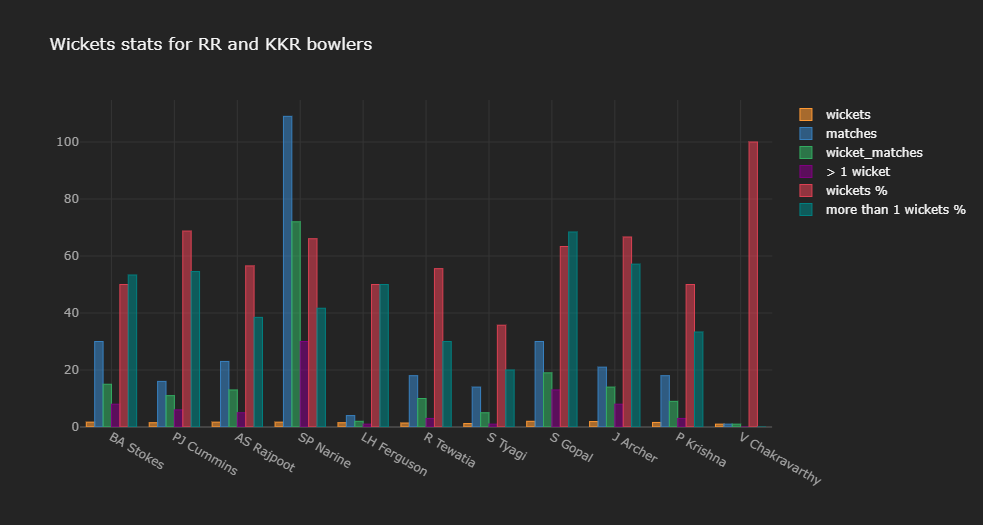

In [40]:
print("total wickets will be : ",wickets_data_RR_KKR[wickets_data_RR_KKR["wickets %"] >=50]["wickets %"].count() + 1) # adding 1 as Kamalesh nagarkoti's data not available

total wickets will be :  11


## Head to head records

In [173]:
wickets_faceoff = deliveries[((deliveries.bowler.isin(KKR_bowlers)) & (deliveries.batsman.isin(RR_batsmen))) | 
                             ((deliveries.bowler.isin(RR_bowlers)) & (deliveries.batsman.isin(KKR_batsmen)))]
wickets_faceoff.player_dismissed.fillna(0, inplace = True)
wickets_RR_KKR_faceoff = wickets_faceoff[(wickets_faceoff.player_dismissed != 0) & (wickets_faceoff.dismissal_kind != 'run out')].groupby(['match_id','bowler'])['player_dismissed'].count().reset_index(name = "wickets")

bowler=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_RR_KKR_faceoff = wickets_taken(wickets_RR_KKR_faceoff, wickets_faceoff)
import numpy as np
import cufflinks as cf

cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_RR_KKR_faceoff.iplot(kind="bar",x = "bowler",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "> 1 wicket", "wickets %", "more than 1 wickets %"],
                  title="Wickets stats for RR and KKR bowlers head to head records",
                  theme="henanigans"
                  )

wickets_data_RR_KKR_faceoff

,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,AS Rajpoot,1.0,5,1,0,20.000000,0.0
1,PJ Cummins,1.0,4,2,0,50.000000,0.0
2,SP Narine,1.0,19,7,0,36.842105,0.0
3,BA Stokes,1.0,8,2,0,25.000000,0.0
4,R Tewatia,1.0,5,1,0,20.000000,0.0
5,J Archer,2.0,4,1,1,25.000000,100.0
6,S Gopal,1.0,5,2,0,40.000000,0.0


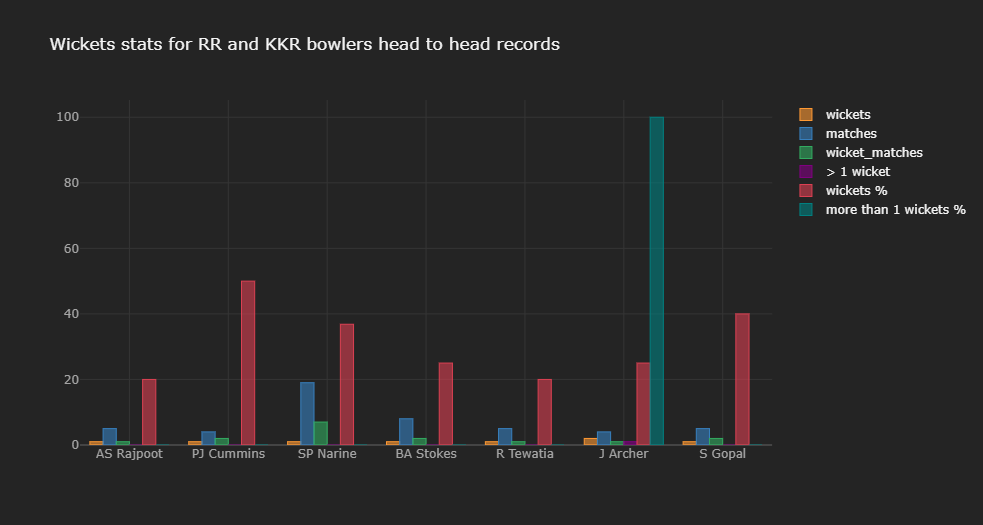

## Conclusion :  11-15 wickets will be taken in today's match

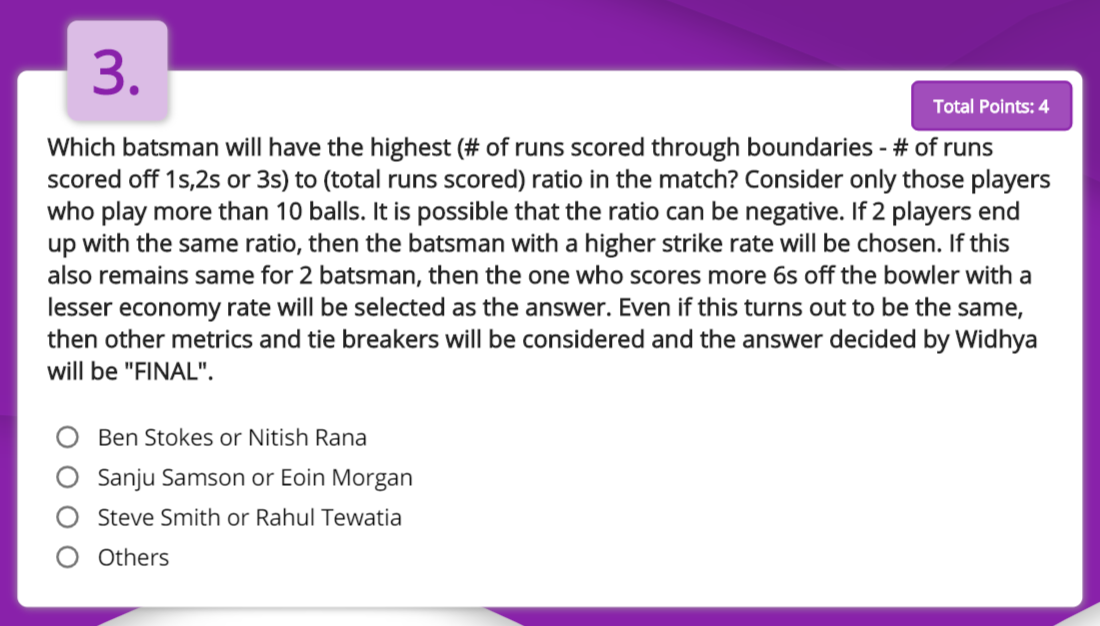

## methods to calculate ratio overall and matchwise average

In [67]:
# Overall performnace in IPL
def runs_off_boundaries(total_score, batsmen_runs, runs_123s):
    off_boundaries = total_score.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    batsmen_boundaries = batsmen_runs.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    runs_1s_2s_3s = runs_123s.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_1s2s3s")
    batsmen_balls_faced = total_score.groupby(['batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
    off_boundaries["runs_offboundaries"] = batsmen_boundaries.runs_offboundaries
    off_boundaries["runs_1s2s3s"] = runs_1s_2s_3s.runs_1s2s3s
    
    off_boundaries["BTR"] = (off_boundaries.runs_offboundaries - off_boundaries.runs_1s2s3s)/off_boundaries.total_score
    
    off_boundaries["strike_rate"] = off_boundaries.total_score*100/batsmen_balls_faced.balls_faced
    off_boundaries.sort_values(by=['BTR'], inplace=True, ascending=False)
    return off_boundaries
###############################################################################################################################
# Matchwise average
def matchwise_runs_off_boundaries(m_total_score, m_batsmen_runs, m_runs_123s):
    matchwise_off_boundaries = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    matchwise_batsmen_boundaries = m_batsmen_runs.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    matchwise_runs_1s_2s_3s = m_runs_123s.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_1s2s3s")
    matchwise_balls_faced = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
    matchwise_off_boundaries["runs_offboundaries"] = matchwise_batsmen_boundaries.runs_offboundaries
    matchwise_off_boundaries["runs_1s2s3s"] = matchwise_runs_1s_2s_3s.runs_1s2s3s
    matchwise_off_boundaries["strike_rate"] = matchwise_off_boundaries.total_score*100/matchwise_balls_faced.balls_faced
    matchwise_off_boundaries.runs_offboundaries.fillna(0, inplace = True)
    bats = [];tscore = [];of_boundaries =[];strike_rate = []; s2s3s=[]
    
    for i in matchwise_off_boundaries.batsman.unique():
        batsmen_boundaries_data = matchwise_off_boundaries[matchwise_off_boundaries.batsman == i]
        bats.append(i)
        tscore.append(batsmen_boundaries_data.total_score.mean())
        strike_rate.append(batsmen_boundaries_data.strike_rate.mean())
        of_boundaries.append(batsmen_boundaries_data.runs_offboundaries.mean())
        s2s3s.append(batsmen_boundaries_data.runs_1s2s3s.mean())
        
    BTR =  pd.DataFrame(list(zip(bats, tscore, of_boundaries, s2s3s, strike_rate)), 
               columns =['batsman', 'total_score', 'runs_offboundaries', 'runs_1s2s3s', 'strike_rate'])
    BTR["BTR"] = (BTR.runs_offboundaries - BTR.runs_1s2s3s)/BTR.total_score
    BTR.sort_values(by = ['BTR'], inplace=True, ascending=False)
    return BTR[['batsman', 'total_score', 'runs_offboundaries', 'runs_1s2s3s','BTR','strike_rate']]

################################################################################################################################
# BTR =  Boundaries - runs 1s2s 3s to Totatl Runs Ratio

### Overall, Head to Head performance 

In [68]:
KKR_RR_batsmen  = deliveries[(deliveries.batsman.isin(RR_batsmen)) | (deliveries.batsman.isin(KKR_batsmen))]
batsmen = KKR_RR_batsmen[((KKR_RR_batsmen.batsman_runs == 4) & (KKR_RR_batsmen.extra_runs != 4)) | 
                          ((KKR_RR_batsmen.batsman_runs == 6) & (KKR_RR_batsmen.extra_runs != 6))]

runs_123 = KKR_RR_batsmen[((KKR_RR_batsmen.batsman_runs ==3) & (KKR_RR_batsmen.extra_runs != 3)) | 
                           ((KKR_RR_batsmen.batsman_runs ==2) & (KKR_RR_batsmen.extra_runs != 2)) | 
                           ((KKR_RR_batsmen.batsman_runs ==1) & (KKR_RR_batsmen.extra_runs != 1))]

# overall 
KKR_RR_boundaries = runs_off_boundaries(KKR_RR_batsmen, batsmen, runs_123)

# matchwise
boundaries_runs_ratio = matchwise_runs_off_boundaries(KKR_RR_batsmen, batsmen, runs_123)

display_side_by_side([KKR_RR_boundaries[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][KKR_RR_boundaries.batsman.isin(KKR_batsmen)], 
                      KKR_RR_boundaries[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][KKR_RR_boundaries.batsman.isin(RR_batsmen)],
                      boundaries_runs_ratio[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][boundaries_runs_ratio.batsman.isin(KKR_batsmen)],
                      boundaries_runs_ratio[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][boundaries_runs_ratio.batsman.isin(RR_batsmen)]], 
                     ['Boundaries to Runs Ratio of KKR Batsmen (Overall)',
                      'Boundaries to Runs Ratio of RR Batsmen (Overall)',
                      'Boundaries to Runs Ratio of KKR batsmen(matchwise average)',
                     'Boundaries to Runs Ratio of RR batsmen(matchwise average)'])

################################################################################################################################
# Head to head 
KKR_RR_faceoff = deliveries[((deliveries.bowler.isin(KKR_bowlers)) & (deliveries.batsman.isin(RR_batsmen))) |
                       ((deliveries.bowler.isin(RR_bowlers)) & (deliveries.batsman.isin(KKR_batsmen)))]
faceoff_batsmen = KKR_RR_faceoff[((KKR_RR_faceoff.batsman_runs == 4) & (KKR_RR_faceoff.extra_runs != 4)) |
                      ((KKR_RR_faceoff.batsman_runs == 6) & (KKR_RR_faceoff.extra_runs != 6))]
runs_123_faceoff = KKR_RR_faceoff[((KKR_RR_faceoff.batsman_runs ==3) & (KKR_RR_faceoff.extra_runs != 3)) | 
                           ((KKR_RR_faceoff.batsman_runs ==2) & (KKR_RR_faceoff.extra_runs != 2)) | 
                           ((KKR_RR_faceoff.batsman_runs ==1) & (KKR_RR_faceoff.extra_runs != 1))]


# overall records head to head in IPL
KKR_RR_boundaries_faceoff = runs_off_boundaries(KKR_RR_faceoff, faceoff_batsmen, runs_123_faceoff)

# matchwise records head to head in IPL
boundaries_runs_ratio_faceoff = matchwise_runs_off_boundaries(KKR_RR_faceoff, faceoff_batsmen, runs_123_faceoff)

display_side_by_side([KKR_RR_boundaries_faceoff[["batsman",'runs_offboundaries', 'runs_1s2s3s', "BTR", "strike_rate"]][KKR_RR_boundaries_faceoff.batsman.isin(KKR_batsmen)], 
                      KKR_RR_boundaries_faceoff[["batsman",'runs_offboundaries', 'runs_1s2s3s', "BTR", "strike_rate"]][KKR_RR_boundaries_faceoff.batsman.isin(RR_batsmen)],
                      boundaries_runs_ratio_faceoff[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][boundaries_runs_ratio_faceoff.batsman.isin(KKR_batsmen)],
                      boundaries_runs_ratio_faceoff[["batsman",'runs_offboundaries', 'runs_1s2s3s',"BTR", "strike_rate"]][boundaries_runs_ratio_faceoff.batsman.isin(RR_batsmen)]], 
                     ['Boundaries to Runs Ratio of KKR Batsmen against RR bowlers(Overall)',
                      'Boundaries to Runs Ratio of RR Batsmen against KKR bowlers(Overall)',
                      'Boundaries to Runs Ratio of KKR batsmen against RR bowlers(matchwise average)',
                     'Boundaries to Runs Ratio of RR batsmen against KKR bowlers(matchwise average)'])


,batsman,runs_offboundaries,runs_1s2s3s,BTR,strike_rate
12,SP Narine,636,131,0.628892,166.943867
5,N Rana,696,384,0.282609,132.215569
9,RA Tripathi,454,301,0.198444,135.026270
1,EJG Morgan,492,362,0.152225,117.793103
6,PJ Cummins,44,33,0.142857,137.500000
4,KD Karthik,2034,1606,0.116052,127.612457
11,S Gill,262,238,0.046422,134.635417
,batsman,runs_offboundaries,runs_1s2s3s,BTR,strike_rate
3,JC Buttler,926,456,0.328442,150.000000
10,RV Uthappa,2676,1718,0.215475,127.319588


,batsman,runs_offboundaries,runs_1s2s3s,BTR,strike_rate
1,EJG Morgan,24.000000,7.000000,inf,0.000000
8,RA Tripathi,22.000000,8.000000,0.823529,141.666667
6,PJ Cummins,14.000000,8.000000,0.666667,180.000000
11,SP Narine,38.000000,30.000000,0.363636,104.761905
10,S Gill,14.000000,5.000000,0.236842,140.740741
5,N Rana,6.000000,3.000000,0.060000,86.206897
4,KD Karthik,26.000000,23.000000,0.023077,158.536585
,batsman,runs_offboundaries,runs_1s2s3s,BTR,strike_rate
3,JC Buttler,94.000000,33.000000,1.452381,113.513514
2,J Archer,26.000000,14.000000,0.375000,228.571429


## Plots for above results

In [171]:
import numpy as np
import cufflinks as cf

def cufflinks_plot(plot_data, label):
    cf.set_config_file(theme='pearl',sharing='public',offline=True)
    plot_data.iplot(kind="bar",x = "batsman",
                            subplots=True,
                          sortbars=True,
                          keys = ["runs_offboundaries", "runs_1s2s3s", "BTR", "strike_rate"],
                          title= label,
                          theme="henanigans")

cufflinks_plot(KKR_RR_boundaries, "(runs off boundaries - runs 1s 2s 3s)/total runs scored [Overall in IPL]")
cufflinks_plot(boundaries_runs_ratio, "(runs off boundaries - runs 1s 2s 3s)/total runs scored [matchwise average]")
cufflinks_plot(KKR_RR_boundaries_faceoff, "(runs off boundaries - runs 1s 2s 3s)/total runs scored [Head to Head for RR and KKR]")
cufflinks_plot(boundaries_runs_ratio_faceoff, "(runs off boundaries - runs 1s 2s 3s)/total runs scored [Head to Head for RR and KKR matchwise average]")

## Answer: Ben Stokes or N Rana

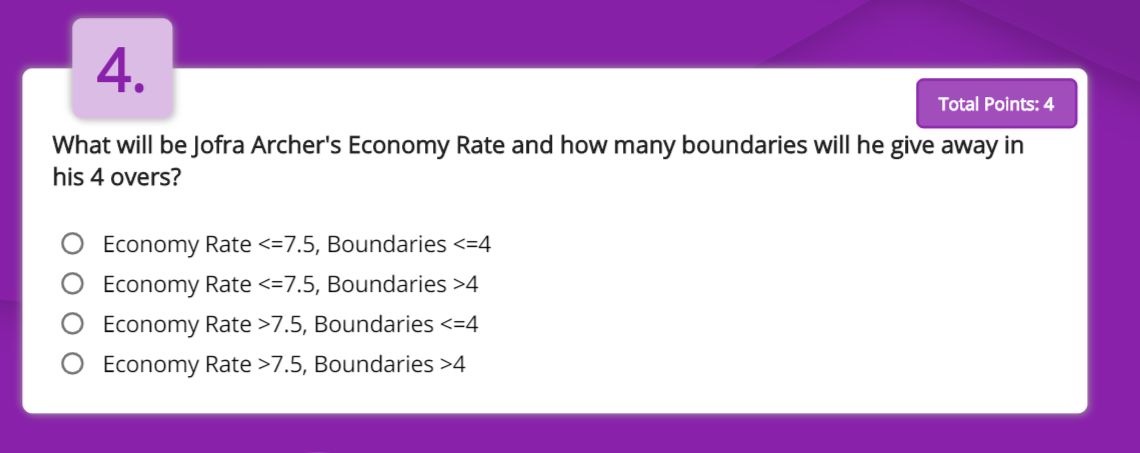

## J Archer Death overs stats (as he is a death over bowler)

## Functions to analyse death over performance of J archer

In [136]:
# plot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip


def J_Archer(jarcher_data):
    archer_ER = jarcher_data.groupby(['match_id'])['batsman_runs'].count().reset_index(name = "balls_bowled")
    archer_runs = jarcher_data.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs_conceeded")
    a_boundaries = jarcher_data[((jarcher_data.batsman_runs == 4) & (jarcher_data.extra_runs != 4)) | ((jarcher_data.batsman_runs == 6) & (jarcher_data.extra_runs != 6))]
    
    archer_boundaries = a_boundaries.groupby(['match_id'])['batsman_runs'].count().reset_index(name = "number_of_boundaries")
    archer_ER["runs_conceeded"] = archer_runs.runs_conceeded
    archer_ER["economy_rate"] = (archer_ER.runs_conceeded/archer_ER.balls_bowled)*6
    archer_ER["no_of_boundaries"] = archer_boundaries.number_of_boundaries
    archer_ER.no_of_boundaries.fillna(0, inplace = True)
    
    return archer_ER

def histogram(data, key, label):
    data.iplot(kind="hist",
                    bins=50, colors=["red"],
                    keys=[key],
                    dimensions=(600, 400),
                    title=label)
    
    


def pie_plot(pie_data,pie_labels, title):
    pie = Pie(sizes=list(pie_data), labels=list(pie_labels),
              stroke="black",
              opacities = [0.8, 0.8],
              radius=150, inner_radius=0,
              sort=True,
              display_values=True, values_format='0.0f',
              label_color="white", font_size="10px", font_weight="bolder"
              )
    fig = Figure(marks=[pie],
             legend_location = "top",
             title=title,
             fig_margin= dict(top=60, bottom=40, left=50, right=20),
             background_style = {"fill":"black"}
                )
    fig.layout.width="500px"
    fig.layout.height="500px"
    pie.tooltip = Tooltip(fields=['sizes'], labels=["Count"], formats=["0.1f"])
    return fig
    


## Performance of J Archer in deaths(overall in IPL)

In [137]:
archer = deliveries[(deliveries.bowler == 'J Archer') & (deliveries.over >=16)]
archer_ER_data = J_Archer(archer)
archer_options = [(archer_ER_data[(archer_ER_data.no_of_boundaries <=4) & (archer_ER_data.economy_rate <=7.5)].shape[0]/archer_ER_data.shape[0])*100,
 (archer_ER_data[(archer_ER_data.no_of_boundaries >4) & (archer_ER_data.economy_rate <=7.5)].shape[0]/archer_ER_data.shape[0])*100,
 (archer_ER_data[(archer_ER_data.no_of_boundaries <=4) & (archer_ER_data.economy_rate >7.5)].shape[0]/archer_ER_data.shape[0])*100,
 (archer_ER_data[(archer_ER_data.no_of_boundaries >4) & (archer_ER_data.economy_rate >7.5)].shape[0]/archer_ER_data.shape[0])*100]

archer_labels = ["[ER <= 7.5, boundaries <= 4]", "[ER <= 7.5, boundaries > 4]" , "[ER > 7.5, boundaries <= 4]", "[ER > 7.5, boundaries > 4]"]
histogram(archer_ER_data, "economy_rate", "Economy Rate of J Archer Matchwise in Death Overs") 
histogram(archer_ER_data, "no_of_boundaries", "no_of_boundaries given by J Archer Matchwise in Death Overs")
fig1  =pie_plot(archer_options ,archer_labels, "J Archer Economy and Boundaries events in deaths")
#fig1


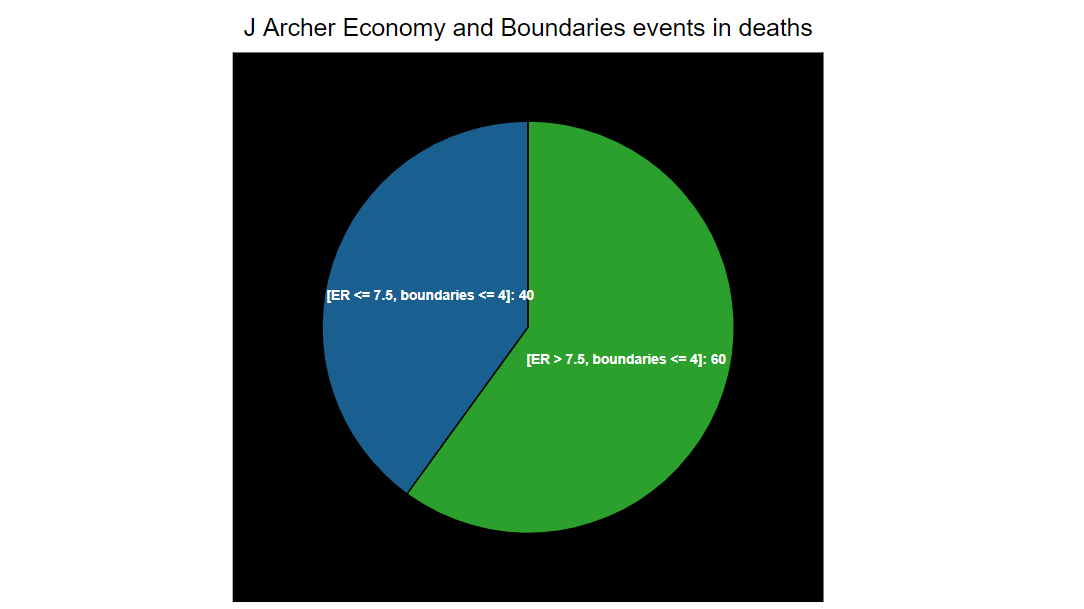

## Against KKR batsmen

In [143]:
archer_KKR = archer[archer.batsman.isin(KKR_batsmen)]
archer_ER_against_KKR = J_Archer(archer_KKR)
archer_ER_against_KKR # both record are against KD Karthik

,match_id,balls_bowled,runs_conceeded,economy_rate,no_of_boundaries
0,7942,4,11,16.5,2
1,11334,4,14,21.0,2


## Conclusion: event will be : ER > 7.5, boundaries <= 4

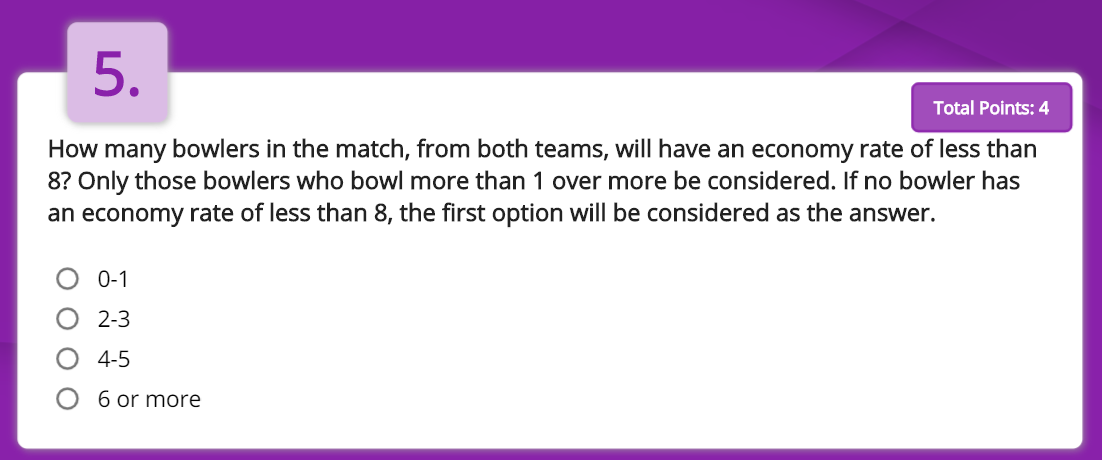

## function to calculate economy rates of RR and KKr bowlers

In [154]:
def economy_rates(bowlers_er):
    for i in bowlers_er.bowler.unique():
        bowl.append(i)
        balls.append(round(bowlers_er[bowlers_er.bowler == i].balls_bowled.mean(),1))
        runs.append(round(bowlers_er[bowlers_er.bowler == i].runs_conceeded.mean(),1))
    
    ER_data = pd.DataFrame(list(zip(bowl, balls, runs)), 
               columns =['bowler','balls_bowled','runs_conceeded'])
    ER_data["economy_rate"] = round(((ER_data.runs_conceeded/ER_data.balls_bowled)*6),1)
    return ER_data

## Overall

In [155]:
bowlers_KKR_RR = deliveries[(deliveries.bowler.isin(KKR_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]
bowlers_ER = bowlers_KKR_RR.groupby(['match_id', 'bowler'])['batsman_runs'].count().reset_index(name ="balls_bowled")
bowlers_runs = bowlers_KKR_RR.groupby(['match_id', 'bowler'])['batsman_runs'].sum().reset_index(name ="runs_conceeded")
bowlers_ER["runs_conceeded"] = bowlers_runs.runs_conceeded
bowlers_ER["economy_rate"] = round(((bowlers_ER.runs_conceeded/bowlers_ER.balls_bowled)*6),1)
bowl=[];balls=[];runs=[]
ER_data_overall = economy_rates(bowlers_ER)
ER_data_overall

,bowler,balls_bowled,runs_conceeded,economy_rate
0,BA Stokes,20.5,27.1,7.9
1,SP Narine,23.9,25.9,6.5
2,PJ Cummins,23.7,29.8,7.5
3,AS Rajpoot,19.7,26.7,8.1
4,LH Ferguson,21.8,21.0,5.8
5,R Tewatia,16.7,19.6,7.0
6,S Tyagi,15.7,20.3,7.8
7,S Gopal,19.8,24.7,7.5
8,J Archer,24.5,30.4,7.4
9,P Krishna,24.3,36.4,9.0


In [162]:
print("Number of bowlers with Economy rate < 8 :", ER_data_overall[ER_data_overall.balls_bowled >6][ER_data_overall.economy_rate<8].shape[0])

Number of bowlers with Economy rate > 8 : 8


## Head to Head

In [157]:
bowlers_ER_faceoff = KKR_RR_faceoff.groupby(['match_id', 'bowler'])['batsman_runs'].count().reset_index(name ="balls_bowled")
bowlers_runs_faceoff = KKR_RR_faceoff.groupby(['match_id', 'bowler'])['batsman_runs'].sum().reset_index(name ="runs_conceeded")
bowlers_ER_faceoff["runs_conceeded"] = bowlers_runs_faceoff.runs_conceeded
bowlers_ER_faceoff["economy_rate"] = round(((bowlers_ER_faceoff.runs_conceeded/bowlers_ER_faceoff.balls_bowled)*6),1)
bowl=[];balls=[];runs=[]
ER_data_overall_faceoff = economy_rates(bowlers_ER_faceoff)
ER_data_overall_faceoff

,bowler,balls_bowled,runs_conceeded,economy_rate
0,BA Stokes,6.1,6.8,6.7
1,AS Rajpoot,6.2,10.8,10.5
2,SP Narine,7.8,8.4,6.5
3,PJ Cummins,5.5,6.5,7.1
4,R Tewatia,3.8,4.0,6.3
5,S Gopal,12.8,16.6,7.8
6,J Archer,10.8,13.8,7.7
7,P Krishna,17.7,28.7,9.7
8,V Chakravarthy,7.0,10.0,8.6


In [164]:
print("Number of bowlers with economy rate <8 :", ER_data_overall_faceoff[ER_data_overall_faceoff.balls_bowled >6][ER_data_overall_faceoff.economy_rate<8].shape[0])

Number of bowlers with economy rate <8 : 4


## Conclusion from above results number of Bowlers with ER less than 8 will be 4-8.<br> Henc, option 6 or more would be right answer by taking centrality measure